Done!


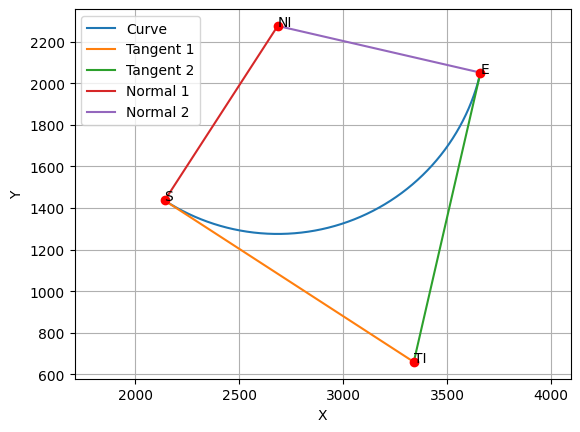

In [16]:
import matplotlib.pyplot as plt
import math
import ifcopenshell
import ifcopenshell.api.alignment
import ifcopenshell.api.unit
import ifcopenshell.geom
import numpy as np

""" Setup the model """
file = ifcopenshell.file(schema="IFC4X3_ADD2")
project = file.createIfcProject(GlobalId=ifcopenshell.guid.new(),Name="Segment Vertices Example")
site = file.createIfcSite(GlobalId=ifcopenshell.guid.new(),Name="Site")

length = ifcopenshell.api.unit.add_conversion_based_unit(file,name="foot")
angle = ifcopenshell.api.unit.add_si_unit(file,unit_type="PLANEANGLEUNIT")
ifcopenshell.api.unit.assign_unit(file,units=[length,angle])
geometric_representation_context = ifcopenshell.api.context.add_context(file, context_type="Model")
axis_model_representation_subcontext = ifcopenshell.api.context.add_context(
    file,
    context_type="Model",
    context_identifier="Axis",
    target_view="MODEL_VIEW",
    parent=geometric_representation_context,
)
body = ifcopenshell.api.context.add_context(
    file,
    context_type="Model", 
    context_identifier="Body", 
    target_view="MODEL_VIEW", 
    parent=geometric_representation_context)

ifcopenshell.api.aggregate.assign_object(file,relating_object=project,products=[site,])

"""
Create a simple alignment with a tangent - circular curve - tangent
"""
start_station = 10000.
alignment = ifcopenshell.api.alignment.create(file,"A-Line",start_station=start_station)
layout = ifcopenshell.api.alignment.get_horizontal_layout(alignment)

segment1 = file.createIfcAlignmentHorizontalSegment(
    StartPoint=file.createIfcCartesianPoint(Coordinates=((500.,2500.))),
    StartDirection=math.radians(327.0613),
    StartRadiusOfCurvature=0.0,
    EndRadiusOfCurvature=0.0,
    SegmentLength=1956.785654,
    PredefinedType = "LINE"
)

end = ifcopenshell.api.alignment.create_layout_segment(file,layout,segment1)

unit_scale = ifcopenshell.util.unit.calculate_unit_scale(file)

x = float(end[0,3])/unit_scale
y = float(end[1,3])/unit_scale
dx = float(end[0,0])
dy = float(end[1,0])
dir = math.atan2(dy,dx)
segment2 = file.createIfcAlignmentHorizontalSegment(
    StartPoint=file.createIfcCartesianPoint((x,y)),
    StartDirection=dir,
    StartRadiusOfCurvature=1000.,
    EndRadiusOfCurvature=1000.,
    SegmentLength=1919.222667,
    PredefinedType="CIRCULARARC"
)
end = ifcopenshell.api.alignment.create_layout_segment(file,layout,segment2)

x = float(end[0,3])/unit_scale
y = float(end[1,3])/unit_scale
dx = float(end[0,0])
dy = float(end[1,0])
dir = math.atan2(dy,dx)
segment3 = file.createIfcAlignmentHorizontalSegment(
    StartPoint=file.createIfcCartesianPoint((x,y)),
    StartDirection=dir,
    StartRadiusOfCurvature=0.0,
    EndRadiusOfCurvature=0.0,
    SegmentLength=1886.905454,
    PredefinedType = "LINE"
)
end = ifcopenshell.api.alignment.create_layout_segment(file,layout,segment3)

"""
Get the geometric representation of segment 2 (the circular curve)
I'm sure there is a better way to do this, but I don't know what it is.... so dumb searching for now
"""
segment = layout.IsNestedBy[0].RelatedObjects[1]
representations = ifcopenshell.util.representation.get_representations_iter(segment)
for representation in representations:
    if representation.RepresentationIdentifier == "Axis" and representation.RepresentationType == "Segment":
        segment_curve = representation.Items[0]
        break

"""
Curves are treated like math functions. The function evaluator is separate from the function (ie. segment_curve)
so that evaluation state is kept in the evaluator.
"""
settings = ifcopenshell.geom.settings()
shape = ifcopenshell.ifcopenshell_wrapper.map_shape(settings,segment_curve.wrapped_data)
evaluator = ifcopenshell.ifcopenshell_wrapper.function_item_evaluator(settings,shape)

"""
Based on the values in settings, the evaluator determines the number of points to be evaluated
"""
distances = evaluator.evaluation_points()

"""
Get the curve points for plotting
"""
x = []
y = []
for d in distances:
    m = evaluator.evaluate(d)
    x.append(np.array(m)[0][3]/unit_scale) # be sure to apply the unit scale, otherwise we get meter instead of feet
    y.append(np.array(m)[1][3]/unit_scale)

# plot the curve
plt.plot(x,y,label="Curve")

# get the segment verticies
s,e,ti,ni = ifcopenshell.api.alignment.segment_vertices(file,segment)

# plot line Start to TI
x = [s[0]/unit_scale,ti[0]/unit_scale]
y = [s[1]/unit_scale,ti[1]/unit_scale]
plt.plot(x,y,label="Tangent 1")

# plot line end to TI
x = [e[0]/unit_scale,ti[0]/unit_scale]
y = [e[1]/unit_scale,ti[1]/unit_scale]
plt.plot(x,y,label="Tangent 2")

# plot line start to NI
x = [s[0]/unit_scale,ni[0]/unit_scale]
y = [s[1]/unit_scale,ni[1]/unit_scale]
plt.plot(x,y,label="Normal 1")

# plot line end to NI
x = [e[0]/unit_scale,ni[0]/unit_scale]
y = [e[1]/unit_scale,ni[1]/unit_scale]
plt.plot(x,y,label="Normal 2")

# label the segment vertex points
plt.plot(s[0]/unit_scale,s[1]/unit_scale,'ro')
plt.annotate("S",(s[0]/unit_scale,s[1]/unit_scale))

plt.plot(e[0]/unit_scale,e[1]/unit_scale,'ro')
plt.annotate("E",(e[0]/unit_scale,e[1]/unit_scale))

plt.plot(ti[0]/unit_scale,ti[1]/unit_scale,'ro')
plt.annotate("TI",(ti[0]/unit_scale,ti[1]/unit_scale))

plt.plot(ni[0]/unit_scale,ni[1]/unit_scale,'ro')
plt.annotate("NI",(ni[0]/unit_scale,ni[1]/unit_scale))


plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.legend()
plt.grid(True)